# Wide-field imaging demonstration

This script makes a fake data set, fills it with a number of point components, and then images it using a variety of algorithms. See imaging-fits for a similar notebook that checks for errors in the recovered properties of the images.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility, create_visibility_from_rows
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, create_w_term_image, invert_by_image_partitions, \
    invert_timeslice, invert_wprojection

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 16.0)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: Visibility has 123255 rows, total size 0.141 GB


Plot the synthesized UV coverage.

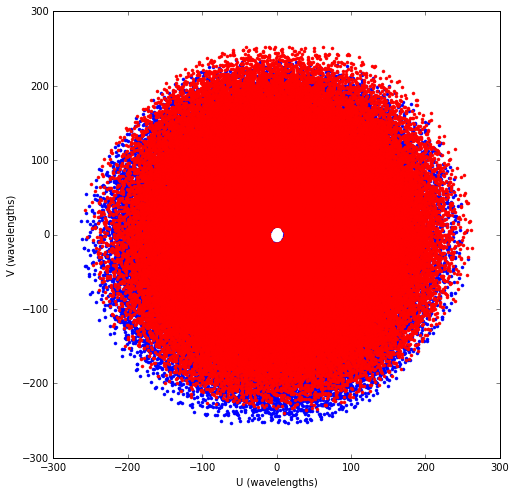

In [4]:
if doplot:
    plt.clf()
    for f in frequency:
        x = f / const.c
        plt.plot(x * vt.data['uvw'][:, 0], x * vt.data['uvw'][:, 1], '.', color='b')
        plt.plot(-x * vt.data['uvw'][:, 0], -x * vt.data['uvw'][:, 1], '.', color='r')
        plt.xlabel('U (wavelengths)')
        plt.ylabel('V (wavelengths)')

Create a grid of components and predict each in turn, using the full phase term including w.

In [5]:
params = {'npixel': 256,
          'npol': 1,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channelwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'image_partitions':4}

npixel = 256
cellsize=0.001
image_partitions = 4
flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
spacing_pixels = npixel // image_partitions
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
        predict_skycomponent_visibility(vt, comp)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Spacing in pixels = 64
Component at (31.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.72799926, -50.26519387)>
Component at (95.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 17.97585392, -50.53155173)>
Component at (159.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 12.20440554, -50.53565248)>
Component at (223.000000, 31.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 6.45109888, -50.2774792)>
Component at (31.000000, 95.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.11770674, -46.61211265)>
Component at (95.00

Make the dirty image and point spread function. 

Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
weight_gridding: Performing uniform weighting
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 94.670128, -17.472163, sumwt = 0.249134


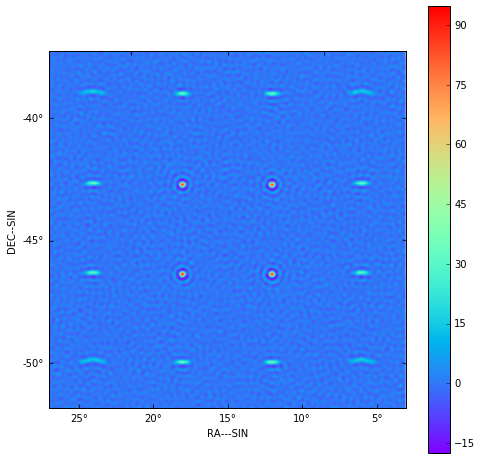

In [6]:
dirty = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
vt, _, _ = weight_visibility(vt, dirty)
dirty, sumwt = invert_2d(vt, dirty)
dirty.data = dirty.data / sumwt
if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

export_image_to_fits(dirty, 'imaging-wterm_dirty.fits')

This occurs because the Fourier transform relationship between sky brightness and visibility is only accurate over small fields of view. 

Hence we can make an accurate image by partitioning the image plane into small regions, treating each separately and then glueing the resulting partitions into one image. We can this image plane partitioning (aka faceting).

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_by_image_partitions: Inverting by image partitions
raster: predicting using 4 x 4 image partitions
raster: spacing of raster (64, 64)
raster: partition 0 (0, 0) of 16
image.operations: created image of shape (1, 1, 64, 64), size 0.000 (GB)
invert_2d: inverting using 2d transform
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.62802131, -50.21418966)>
get_ftprocessor_params: effective uv cellsize is 7.8 wavelengths
get_ftpr

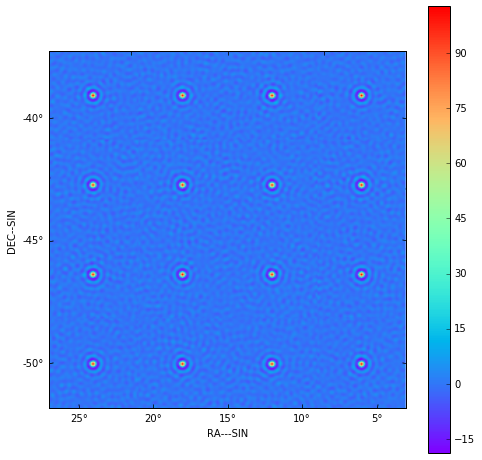

In [7]:
dirtyFacet = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
dirtyFacet, sumwt = invert_by_image_partitions(vt, dirtyFacet, image_iterator=raster_iter, 
                                               image_partitions=4)
dirtyFacet.data = dirtyFacet.data / sumwt

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), sumwt))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet.fits')

That was the best case. This time, we will not arrange for the partitions to be centred on the sources. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_by_image_partitions: Inverting by image partitions
raster: predicting using 2 x 2 image partitions
raster: spacing of raster (128, 128)
raster: partition 0 (0, 0) of 4
image.operations: created image of shape (1, 1, 128, 128), size 0.001 (GB)
invert_2d: inverting using 2d transform
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 20.5474107, -48.54356678)>
get_ftprocessor_params: effective uv cellsize is 3.9 wavelengths
get_ft

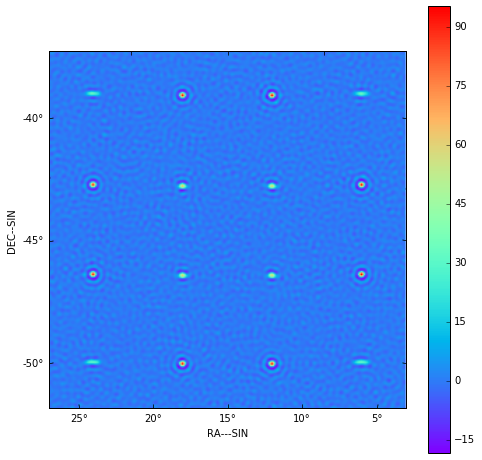

In [8]:
dirtyFacet2 = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
dirtyFacet2, sumwt = invert_by_image_partitions(vt, dirtyFacet2, image_iterator=raster_iter, image_partitions=2)
dirtyFacet2.data = dirtyFacet2.data / sumwt

if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), sumwt))
export_image_to_fits(dirtyFacet2, 'imaging-wterm_dirtyFacet2.fits')

The w-term can also be viewed as a time-variable distortion. 

To illustrate this, we will construct images as a function of time. For comparison, we show difference of each time slice from the best facet image. Instantaneously the sources are un-distorted but do lie in the wrong location.

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 193.050761 wavelengths
create_image_from_visibility: Critical cellsize = 0.002590 radians, 0.148396 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 109.993129, -34.595297, sumwt = 0.024200


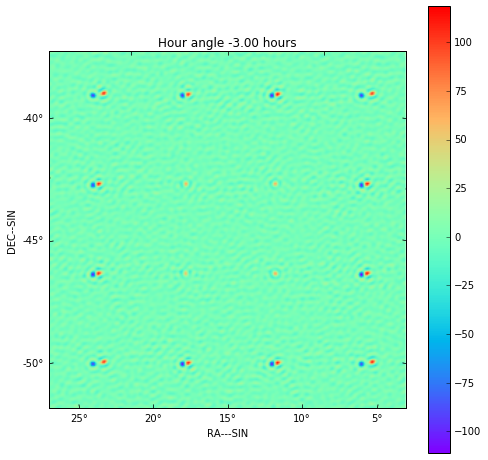

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 223.135547 wavelengths
create_image_from_visibility: Critical cellsize = 0.002241 radians, 0.128388 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 106.722089, -33.331080, sumwt = 0.026712


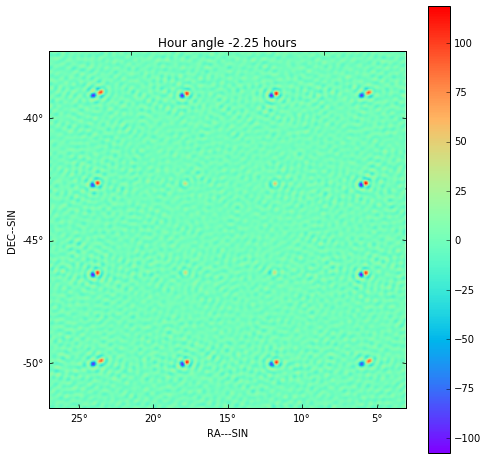

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 245.923484 wavelengths
create_image_from_visibility: Critical cellsize = 0.002033 radians, 0.116491 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 94.925472, -26.527832, sumwt = 0.028497


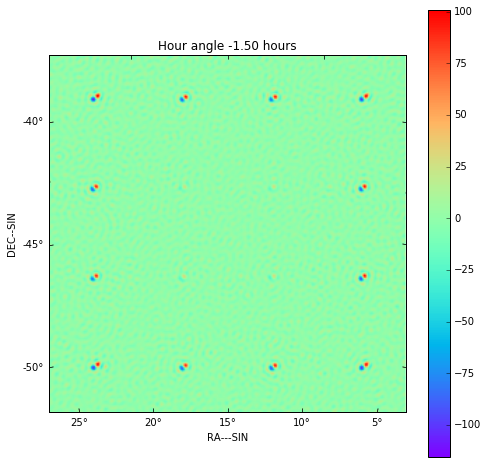

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 259.260719 wavelengths
create_image_from_visibility: Critical cellsize = 0.001929 radians, 0.110498 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 101.676881, -28.242888, sumwt = 0.030046


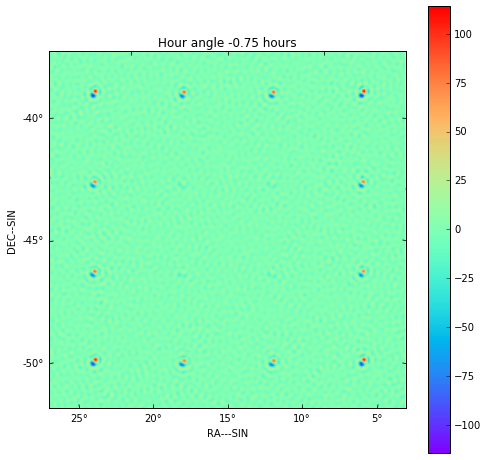

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 107.674782, -29.393704, sumwt = 0.030140


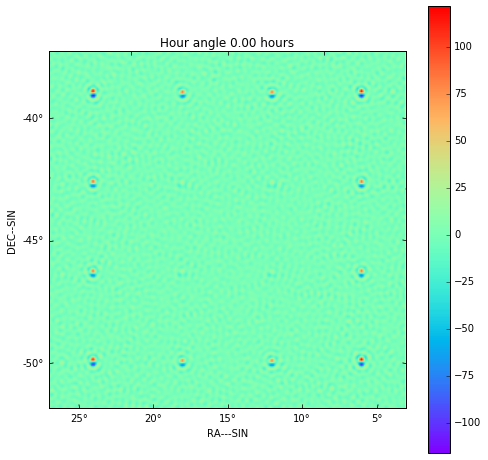

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 256.867481 wavelengths
create_image_from_visibility: Critical cellsize = 0.001947 radians, 0.111528 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 101.422881, -29.388189, sumwt = 0.029761


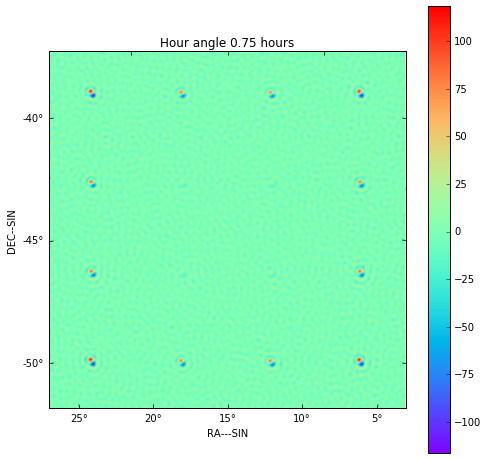

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 246.828152 wavelengths
create_image_from_visibility: Critical cellsize = 0.002026 radians, 0.116064 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 100.874143, -31.712159, sumwt = 0.028632


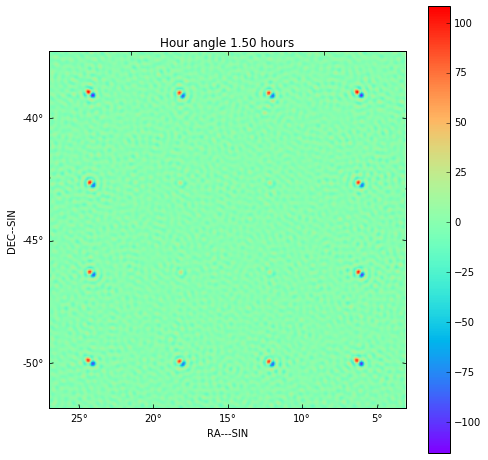

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 230.159619 wavelengths
create_image_from_visibility: Critical cellsize = 0.002172 radians, 0.124470 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 98.896709, -30.007869, sumwt = 0.026804


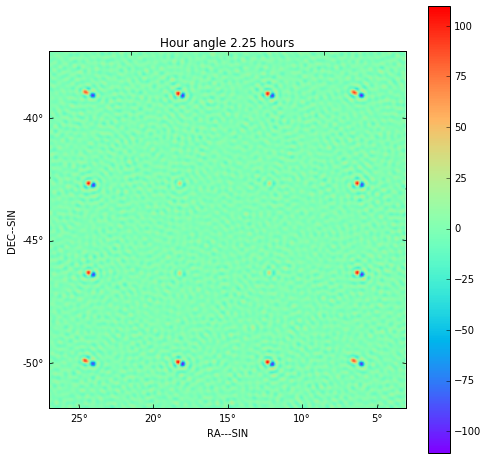

create_visibility_from_rows: Created view into visibility table
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 204.646182 wavelengths
create_image_from_visibility: Critical cellsize = 0.002443 radians, 0.139987 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in dirty image = 100.512853, -33.894313, sumwt = 0.024343


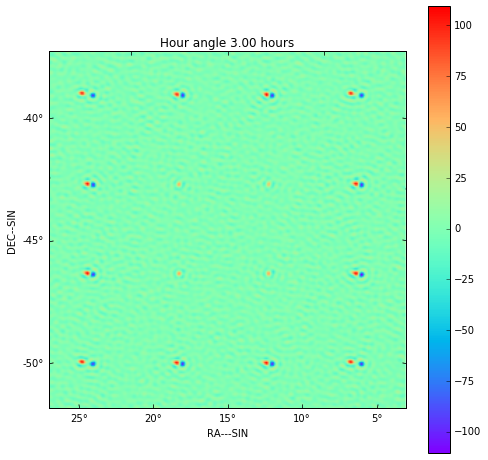

In [9]:
for rows in vis_timeslice_iter(vt, timeslice=1.0):
    visslice = create_visibility_from_rows(vt, rows)
    dirtySnapshot = create_image_from_visibility(visslice, npixel=256, cellsize=0.001, npol=1)
    dirtySnapshot, sumwt = invert_2d(visslice, dirtySnapshot)

    dirtySnapshot.data /= sumwt

    print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), sumwt))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)
        plt.title("Hour angle %.2f hours" % (numpy.average(visslice.time) * 12.0 / 43200.0))
        plt.show()

This timeslice imaging leads to a straightforward algorithm in which we correct each time slice and then sum the resulting timeslices. 

This lends itself to parallel processing, so we do this in parallel using 4 processes

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_timeslice: inverting using time slices
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
create_visibility_from_rows: Created view into visibility table
predict_timeslice: Fit to 13695 rows reduces rms w from 178.5 to 0.0 wavelengths
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)

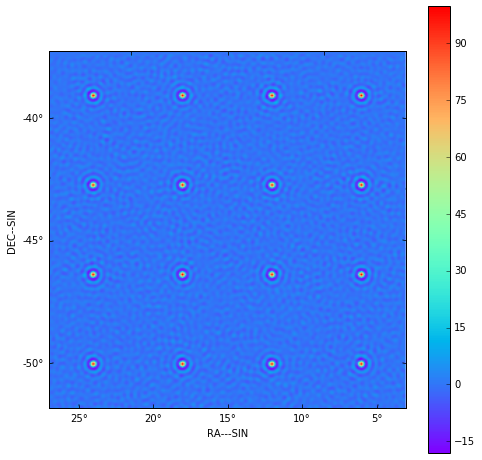

Max, min in dirty image = 99.652734, -18.005814, sumwt = 0.249134


In [10]:
dirtyTimeslice = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
dirtyTimeslice, sumwt= invert_timeslice(vt, dirtyTimeslice, timeslice=1.0, padding=2, nprocessor=1)

dirtyTimeslice.data /= sumwt
show_image(dirtyTimeslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyTimeslice.data.max(), dirtyTimeslice.data.min(), sumwt))

export_image_to_fits(dirtyTimeslice, 'imaging-wterm_dirty_Timeslice.fits')

Finally we try w projection. 

The w term in multiplicative in the image plane, parametrised by w. In this plot, we use the median of the absolute value of w.

create_w_term_image: Creating w term image for median w 87.303815
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
create_w_term_image: Fresnel number for median w and this field of view and sampling = 1.43


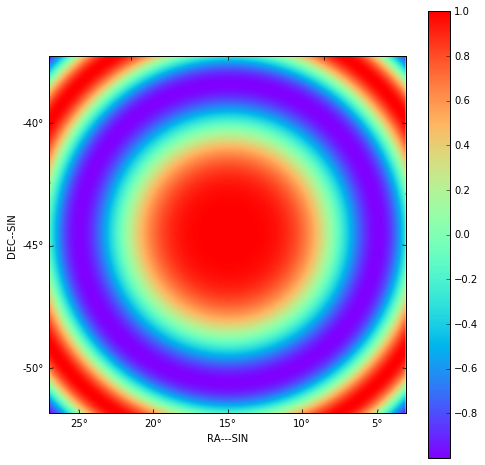

In [11]:
if doplot:
    wterm = create_w_term_image(vt, npixel=256, cellsize=0.001, npol=1)
    show_image(wterm)
    plt.show()

This can be restated as a convolution in Fourier space. 

Hence when gridding, we can use the transform of the w beam to correct this effect while gridding. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: unknown spectral mode 
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
invert_2d: inverting using wprojection
get_ftprocessor_params: effective uv cellsize is 3.9 wavelengths
get_ftprocessor_params: Channel synthesis mode
get_ftprocessor_params: using wprojection kernel
get_ftprocessor_params: Fresnel number = 16.384000
get_ftprocessor_params: Recommended wstep = 0.971405
get_ftprocessor_params: Using w projection with wstep = 10.000000
get_ftprocessor_params: w kernel full width = 16 pixels
w_kernel_lambda: Maximum w = 169.644411 wavelengths
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
Max, min in di

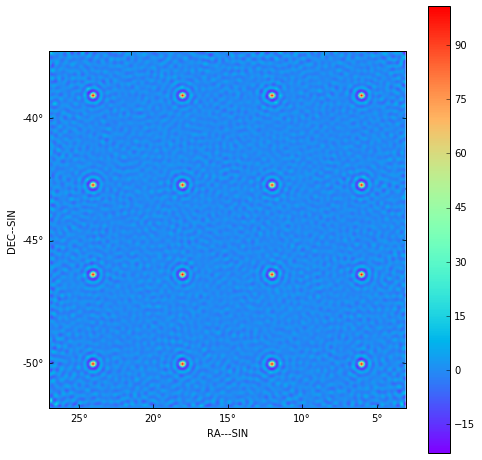

In [12]:
dirtyWProjection = create_image_from_visibility(vt, npixel=256, cellsize=0.001, npol=1)
dirtyWProjection, sumwt = invert_wprojection(vt, dirtyWProjection, wstep=10.0, kernelwidth=16, padding=1,
                                            oversampling=4)
dirtyWProjection.data = dirtyWProjection.data / sumwt

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), sumwt))
export_image_to_fits(dirtyWProjection, 'imaging-wterm_dirty_WProjection.fits')
